# Setup

In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
from FittedModels.utils import plot_distributions
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.BayesianNN import PosteriorBNN
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_distributions, plot_history, plot_samples
from FittedModels.train import LearntDistributionManager
from Utils import plot_func2D, MC_estimate_true_expectation
from Utils import plot_distribution

### Expectation Function

In [8]:
def expectation_function(x):
    A = torch.ones((x.shape[-1], x.shape[-1]))
    return torch.einsum("bi,ij,bj->b", x, A, x)

# Specifiy target distribution and key param

### Easy and Plottable

In [13]:
torch.manual_seed(1)
target = PosteriorBNN(n_datapoints=2, x_dim=1, y_dim=1, n_hidden_layers=0, layer_width=0
                             ,linear_activations=True, fixed_variance=True, use_bias=True)

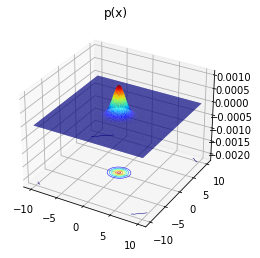

In [14]:
p_x_fig = plot_distribution(target, n_points=100)

### Harder

In [3]:
target = PosteriorBNN(n_datapoints=10, x_dim=2, y_dim=1, n_hidden_layers=1, layer_width=1)

## Setup

In [5]:
epochs = 1000
n_samples_estimation = int(1e4)
dim = target.n_parameters
print(dim)

7


# DReG
Let's instantiate a flow based model, and train using DReG

In [15]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
fig_before_train = plot_distributions(tester)

In [16]:
history = tester.train(400, batch_size=100)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: -101.48323822021484, mean log p_x -8.118000149541683e+16: 100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [01:24<00:00,  4.73it/s]


(-100000.0, 20.0)

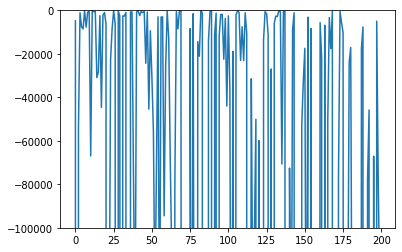

In [34]:
plt.plot(history["log_p_x"])
plt.ylim([-100000, 20])

(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

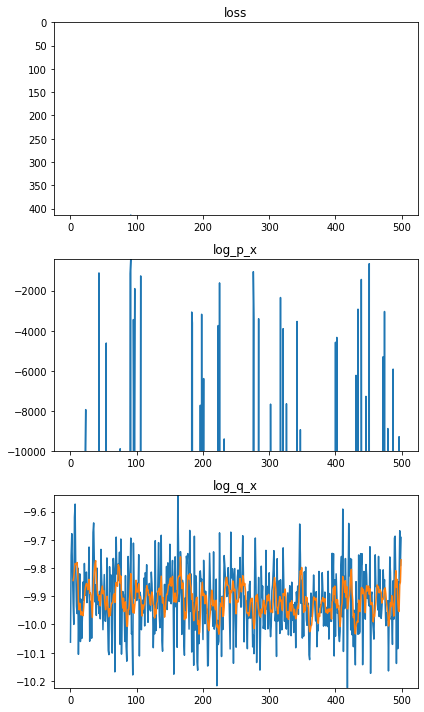

In [21]:
plot_history(history, bounds=[-1e4, 0])

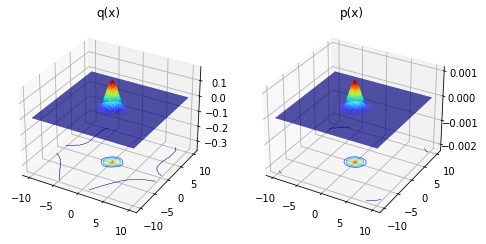

In [24]:
fig_after_train = plot_distributions(tester)

In [56]:
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 4.361915111541748 
estimate after training is 4.277743816375732 
effective sample size before is 237.40396118164062 out of 10000 
effective sample size after is 399.3623962402344 out of 10000  
variance in weights is 2.404231906893983e-07


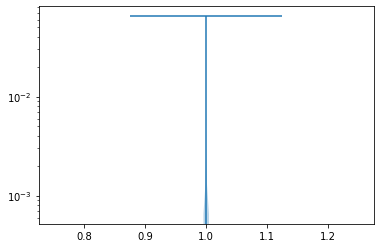

In [35]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

# KL

In [59]:
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=10)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
history = tester.train(1000, batch_size=100) #epochs
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 46779.07421875, mean log p_x -46789.0:   6%|██████▎                                                                                            | 64/1000 [00:15<03:40,  4.24it/s]

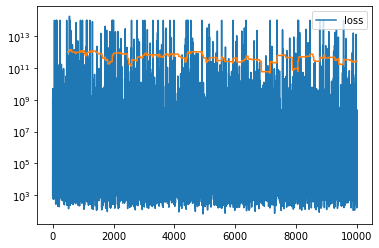

In [58]:
import pandas as pd
data = pd.Series(history["loss"])
rolling_interval = int(len(data) / 20)
plt.plot(data)
plt.plot(data.rolling(rolling_interval).mean())
plt.yscale("log")
plt.legend(["loss"])

In [46]:
history["log_q_x"]

[-9.687636375427246,
 -9.82983112335205,
 -9.73159408569336,
 -10.200383186340332,
 -10.017589569091797,
 -9.540589332580566,
 -10.159278869628906,
 -9.520238876342773,
 -10.1082763671875,
 -9.884581565856934,
 -9.727215766906738,
 -9.995196342468262,
 -9.866840362548828,
 -9.817486763000488,
 -9.840012550354004,
 -9.704684257507324,
 -10.051295280456543,
 -10.008310317993164,
 -9.8561429977417,
 -9.912802696228027,
 -9.869970321655273,
 -10.073249816894531,
 -9.879483222961426,
 -10.059115409851074,
 -9.904459953308105,
 -10.035135269165039,
 -10.026244163513184,
 -9.87417984008789,
 -9.73000717163086,
 -10.129324913024902,
 -9.869606971740723,
 -9.361583709716797,
 -10.291031837463379,
 -9.9208345413208,
 -9.676610946655273,
 -10.145700454711914,
 -9.986321449279785,
 -9.706315040588379,
 -9.906034469604492,
 -10.085426330566406,
 -10.122671127319336,
 -9.740547180175781,
 -10.160694122314453,
 -9.940144538879395,
 -9.870084762573242,
 -10.173120498657227,
 -9.814035415649414,
 -10.1

In [51]:
max(history["log_p_x"])

-77.05009460449219

(<Figure size 432x720 with 3 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'log_p_x'}>,
        <AxesSubplot:title={'center':'log_q_x'}>], dtype=object))

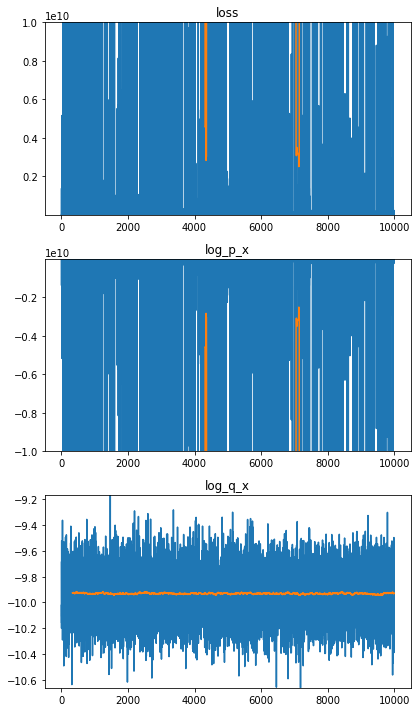

In [52]:
plot_history(history, bounds=[-1e10, 1e10])

In [45]:
print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
      f"effective sample size before is {info_before['effective_sample_size']} out of {n_samples_estimation} \n"
     f"effective sample size after is {info['effective_sample_size']} out of {n_samples_estimation}  \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 4.361915111541748 
estimate after training is 4.277743816375732 
effective sample size before is 237.40396118164062 
effective sample size after is 399.3623962402344 
variance in weights is 2.404231906893983e-07


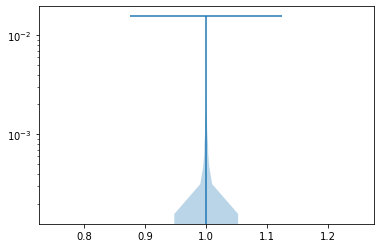

In [24]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

# Gaussain

In [ ]:
epochs = 500
n_samples_estimation = int(1e4)
target = PosteriorBNN(n_datapoints=1, x_dim=1, y_dim=1, n_hidden_layers=1, layer_width=2)
dim = target.n_parameters

In [ ]:
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian

In [ ]:
n_samples_estimation = int(1e4)
learnt_sampler = DiagonalGaussian(dim=dim)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")

In [ ]:
history = tester.train(epochs)

In [ ]:
plot_history(history)